In [10]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import numpy.linalg as la
from PIL import Image

def perc_high(a):
    return np.percentile(a,q=90)

def perc_low(a):
    return np.percentile(a,q=10)

def load_fitness(filename):
    ids = []
    fits = []
    parents = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            ids.append(float(row[0]))
            fits.append(float(row[-2]))
            parents.append(int(row[1]))
    return ids, fits, parents

def load_nbr_evaluations(filename):
    idx_eval = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        i = 0;
        for row in csv_data:
            idx_eval[int(row[0])] = [i,int(row[1])]
            i+=1
    return idx_eval

def find_index(_id,ids):
    for i in range(len(ids)):
        if(ids[i] == _id):
            return i

def compute_gen_rec(par_id,ids,parents):
    if(par_id == -1):
        return 0
    for i, id in zip(range(len(ids)),ids):
        if(par_id == id):
            return compute_gen_rec(parents[i],ids,parents) + 1

def compute_generation(ids,parents):
    generation = [0 for _ in range(len(ids))]
    for i in range(len(ids)):
        generation[i] = compute_gen_rec(parents[i],ids,parents)
    return generation

def load_descriptor(filename) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(len(row)-1) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return descriptors
    
def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(row[0]=='0 0 0 0'):
                continue
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                if(coord[1] == 0):
                    lines.append([coord[0],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of sensors","fitness"])

def compute_lineage_rec(ids,par_id,parents):
    if(par_id == -1):
        return []
    for i, _id in zip(range(len(ids)),ids):
        if(par_id == _id):
            return [_id] + compute_lineage_rec(ids,parents[i],parents)
def compute_lineage(ids,parents):
    lineages = dict()
    for i, _id in zip(range(len(ids)),ids):
        lineages[_id] = compute_lineage_rec(ids,parents[i],parents)
    return lineages

def load_trajectory(filename):
    traj = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=';')
        t = 0
        for row in csv_data:
            position = row[0].split(',')
            pos = [float(elt) for elt in position]
            traj.append([t] + pos)
            t+=1
    return traj

def compute_runtime(filename,nbr_eval):
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        i = 0
        start_time = 0
        end_time = 0
        for row in csv_data:
            if(i==0):
                start_time = float(row[1])
            if(row[0] == "overhead"):
                continue
            if(i==nbr_eval):
                end_time = float(row[2])
            i+=1
    return end_time - start_time

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

# Gradual Navigation
## Quality

6


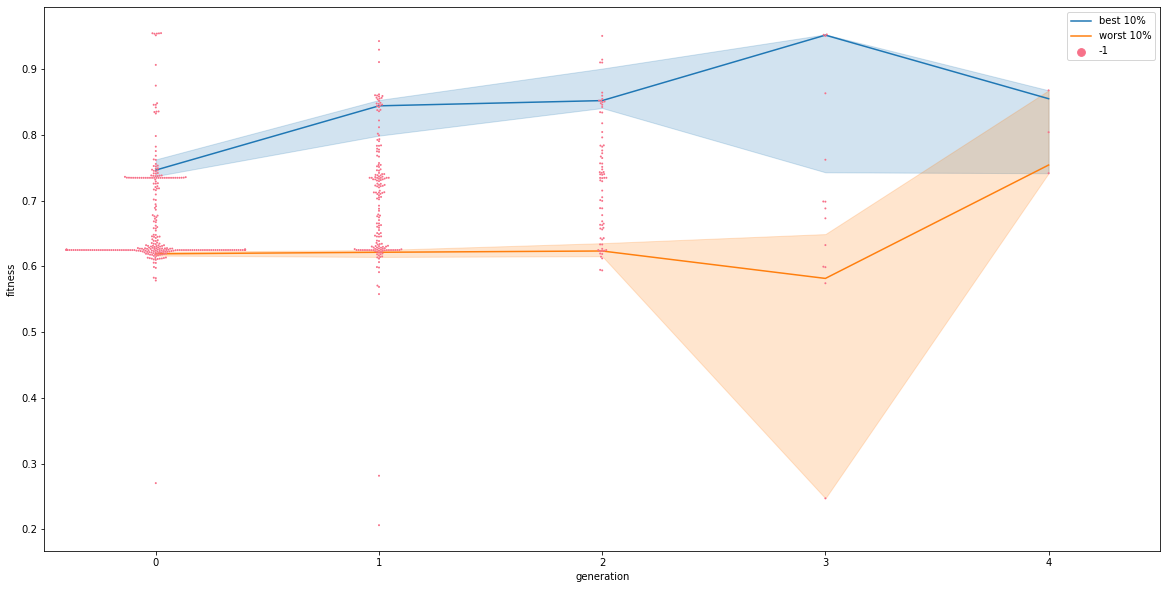

In [16]:
exp_folder = "/home/leni/are-logs/mnipes_gradual2/"
colors = sns.color_palette("husl", 7)
lines = []
i = 0
   
for folder in os.listdir(exp_folder):
    i+=1
    id_env = dict()
    if(os.path.isfile(exp_folder + "/" + folder)):
        continue
    for file in os.listdir(exp_folder + "/" + folder):
        if(file.split("_")[0] != "traj"):
            continue
        _id = int(file.split("_")[1])
        env = int(file.split("_")[2])
        traj = load_trajectory(exp_folder + "/" + folder + "/" + file)
        if(len(traj) > 0):
            if _id in id_env:
                if env > id_env[_id]:
                    id_env[_id] = env
            else:
                id_env[_id] = env
    idx, fitnesses, parents = load_fitness(exp_folder + "/" + folder + "/fitnesses.csv")
    idx_eval = load_nbr_evaluations(exp_folder + "/" + folder + "/number_of_evaluations.csv")
    generation = compute_generation(idx,parents)
    for _id, fit, gen in zip(idx,fitnesses,generation):
        if(not _id in id_env):
            lines.append([_id,idx_eval[_id][0],idx_eval[_id][1],fit,gen,-1])
        else:
            lines.append([_id,fit,idx_eval[_id][0],idx_eval[_id][1],gen,id_env[_id]])             
            
print(i)
data = pd.DataFrame(data=lines,columns=["robot id","index","evaluations","fitness","generation","env"]) 
data.drop_duplicates()
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.swarmplot(data=data,x="generation",y="fitness",hue="env",size=2,color='b',palette=colors)
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_high,label="best 10%")
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_low,label="worst 10%")

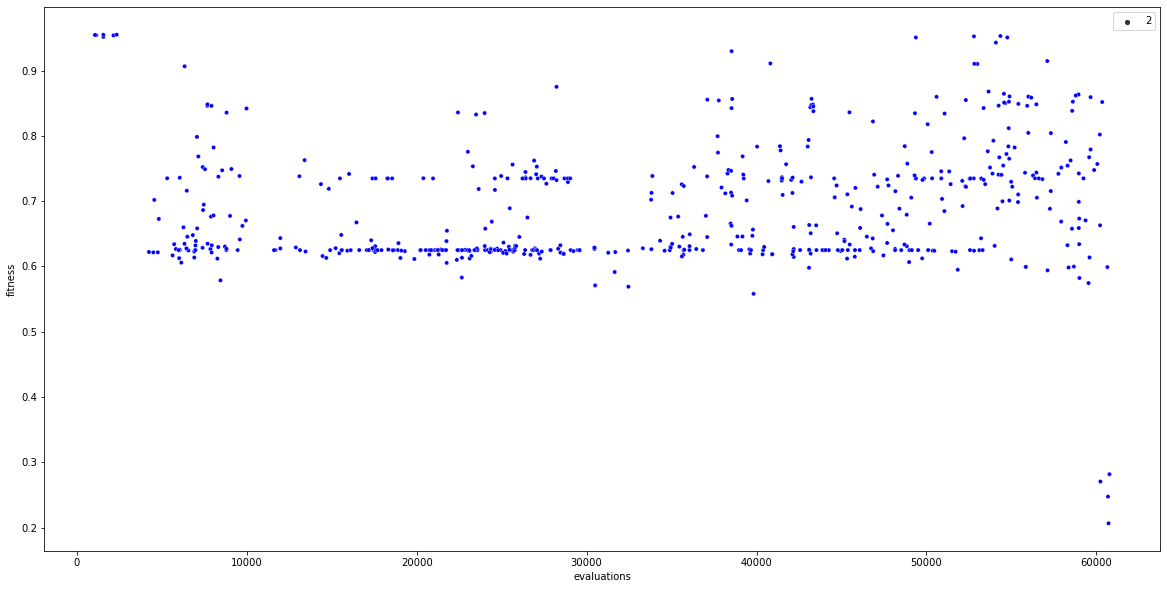

In [20]:
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.scatterplot(data=data,x="evaluations",y="fitness",size=2,color='b')

change_task_logs
mnipes2_26_4_13-39-31-1599-769912008


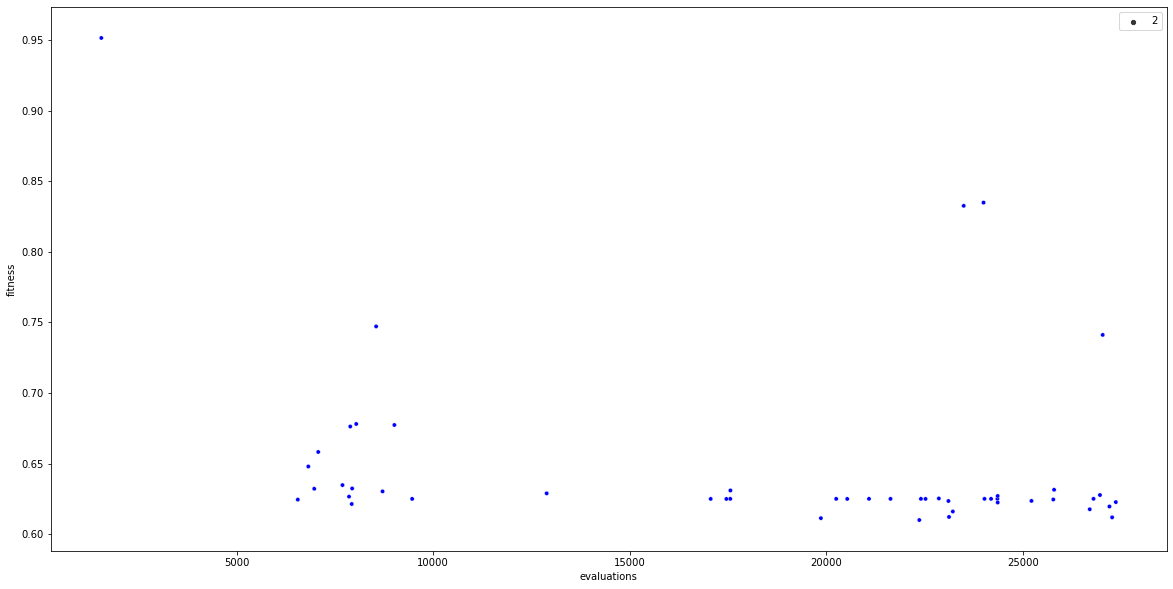

mnipes2_26_4_13-39-50-972-5859924


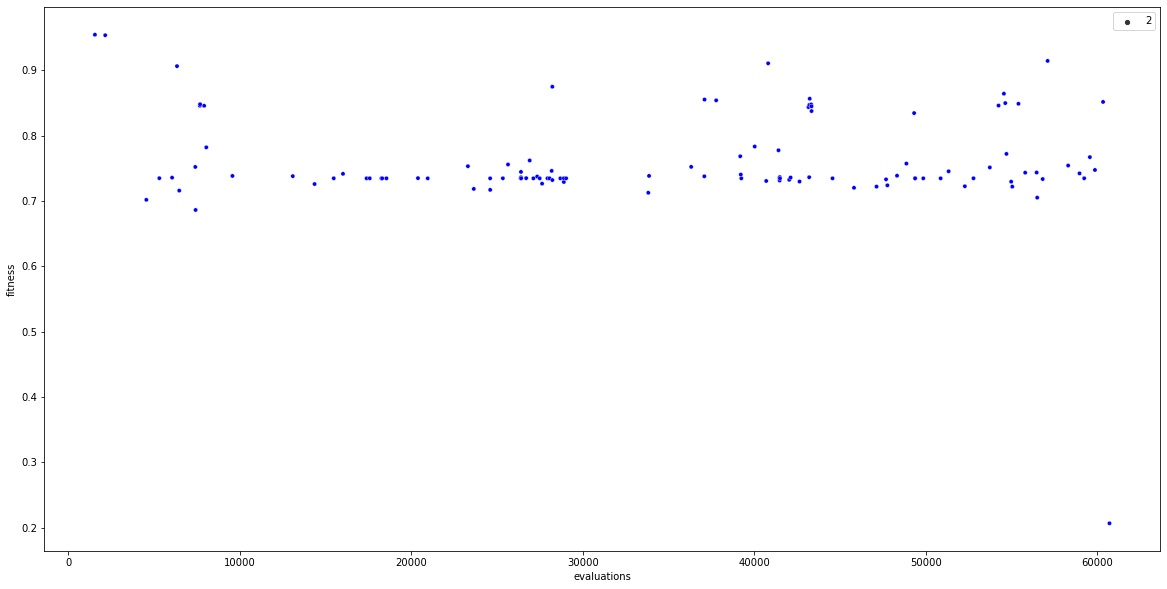

mnipes2_26_4_13-39-57-7296-397148113


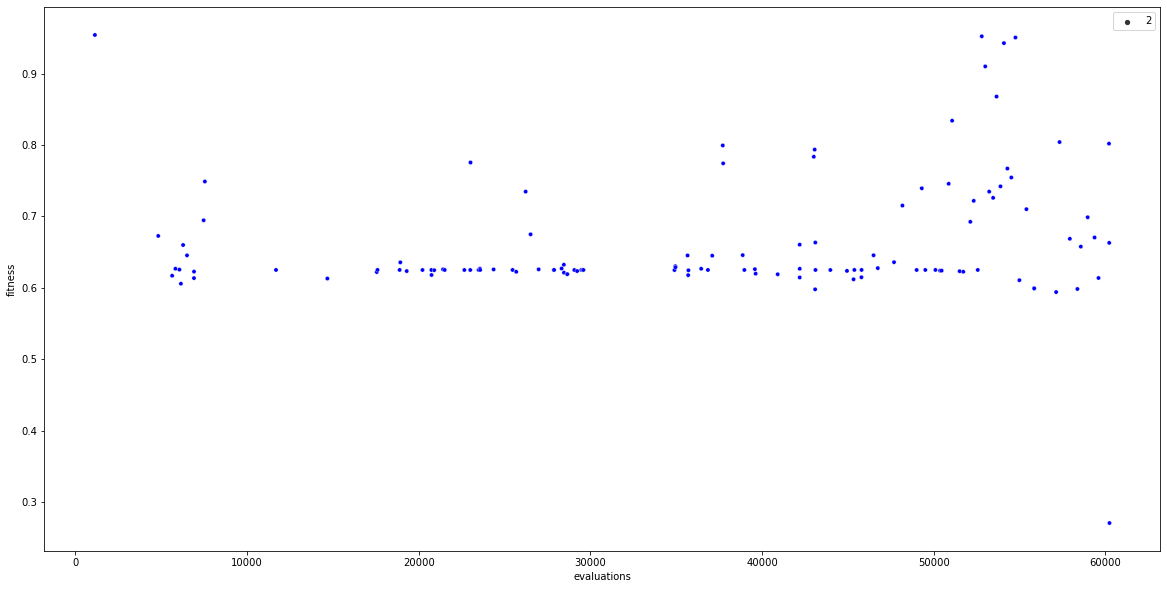

mnipes2_26_4_13-39-39-9878-1546965217


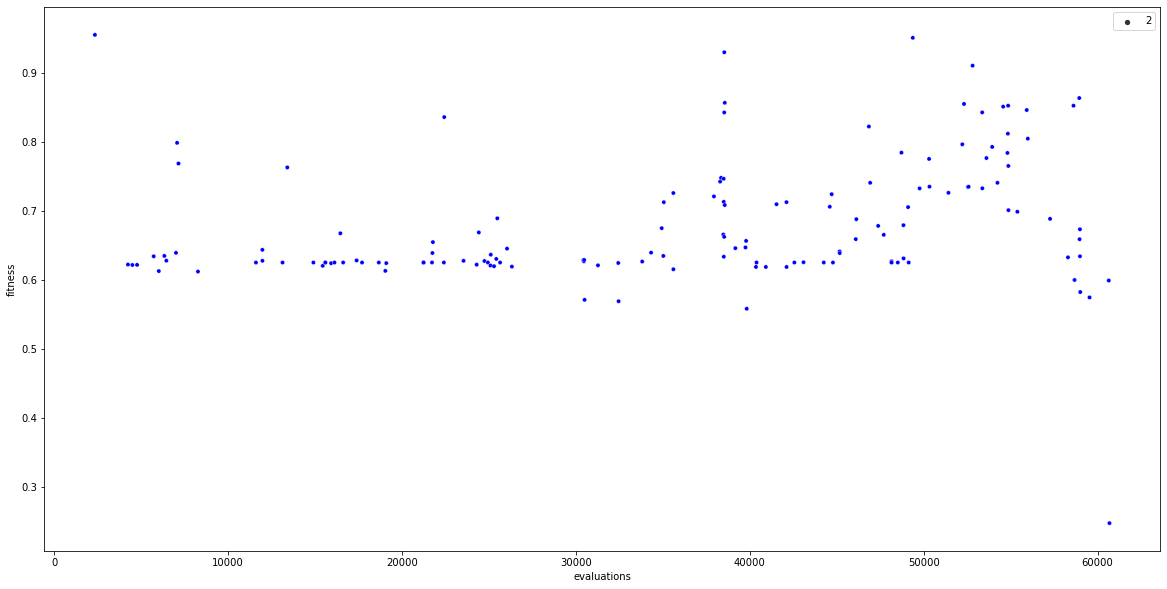

mnipes2_26_4_13-39-39-9729-1582887243


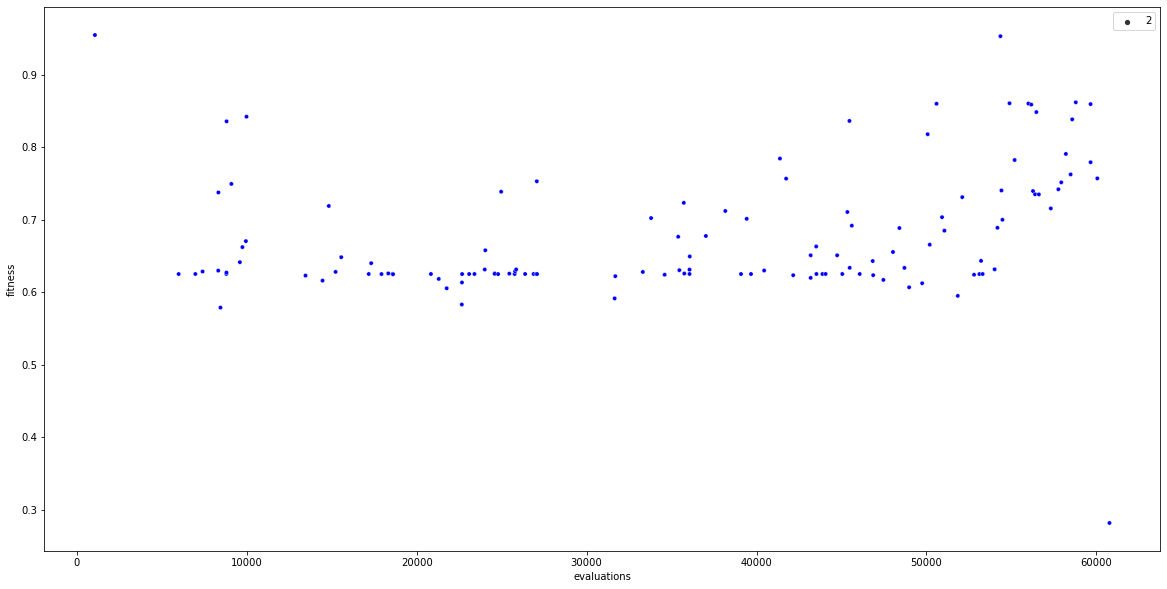

In [21]:
exp_folder = "/home/leni/are-logs/mnipes_gradual2/"
for folder in os.listdir(exp_folder):
    print(folder)
    lines = []
    id_env = dict()
    if(os.path.isfile(exp_folder + "/" + folder)):
        continue
    for file in os.listdir(exp_folder + "/" + folder):
        if(file.split("_")[0] != "traj"):
            continue
        _id = int(file.split("_")[1])
        env = int(file.split("_")[2])
        traj = load_trajectory(exp_folder + "/" + folder + "/" + file)
        if(len(traj) > 0):
            if _id in id_env:
                if env > id_env[_id]:
                    id_env[_id] = env
            else:
                id_env[_id] = env
    idx, fitnesses, parents = load_fitness(exp_folder + "/" + folder + "/fitnesses.csv")
    idx_eval = load_nbr_evaluations(exp_folder + "/" + folder + "/number_of_evaluations.csv")
    generation = compute_generation(idx,parents)
    for _id, fit, gen in zip(idx,fitnesses,generation):
        if(not _id in id_env):
            lines.append([_id,idx_eval[_id][0],idx_eval[_id][1],fit,gen,-1])
        else:
            lines.append([_id,fit,idx_eval[_id][0],idx_eval[_id][1],gen,id_env[_id]]) 
    data = pd.DataFrame(data=lines,columns=["robot id","index","evaluations","fitness","generation","env"]) 
    fig = plt.gcf()
    fig.set_size_inches(20,10)
    ax = sns.scatterplot(data=data,x="evaluations",y="fitness",size=2,color='b')
    plt.show()

In [23]:
exp_folder = "/home/leni/are-logs/mnipes_gradual/mnipes2_16_4_12-39-1-1770-405870621/"
env_name = ["arena","escape easy","escape hard","multi easy","multi hard","hard race"]
lines = []
id_env = dict()
for file in os.listdir(exp_folder):
    if(file.split("_")[0] != "traj"):
        continue
    _id = int(file.split("_")[1])
    env = int(file.split("_")[2])
    traj = load_trajectory(exp_folder + "/" + file)
    if(len(traj) > 0):
        if _id in id_env:
            if env > id_env[_id]:
                id_env[_id] = env
        else:
            id_env[_id] = env
    idx, fitnesses, parents = load_fitness(exp_folder + "/fitnesses.csv")
    idx_eval = load_nbr_evaluations(exp_folder + "/number_of_evaluations.csv")
    generation = compute_generation(idx,parents)
    for _id, fit, gen in zip(idx,fitnesses,generation):
        if(not _id in id_env):
            lines.append([_id,idx_eval[_id][0],idx_eval[_id][1],fit,gen,-1])
        else:
            lines.append([_id,fit,idx_eval[_id][0],idx_eval[_id][1],gen,id_env[_id]]) 

data = pd.DataFrame(data=lines,columns=["robot id","index","evaluations","fitness","generation","env"]) 
data.drop_duplicates()
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.scatterplot(data=data,x="robot id",y="fitness",hue="env",palette=sns.color_palette(n_colors=6))
ax.axhline([0.95])
ax.set_title("photo taxis - incremental tasks")
plt.show()
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.swarmplot(data=data,x="generation",y="fitness",hue="env",size=3,color='b',palette=sns.color_palette(n_colors=6))
ax.axhline([0.95])
sns.lineplot(data=data,x="generation",y="fitness",estimator=max,label="best")
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_low,label="worst 10%")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/leni/are-logs/mnipes_gradual/mnipes2_16_4_12-39-1-1770-405870621//number_of_evaluations.csv'

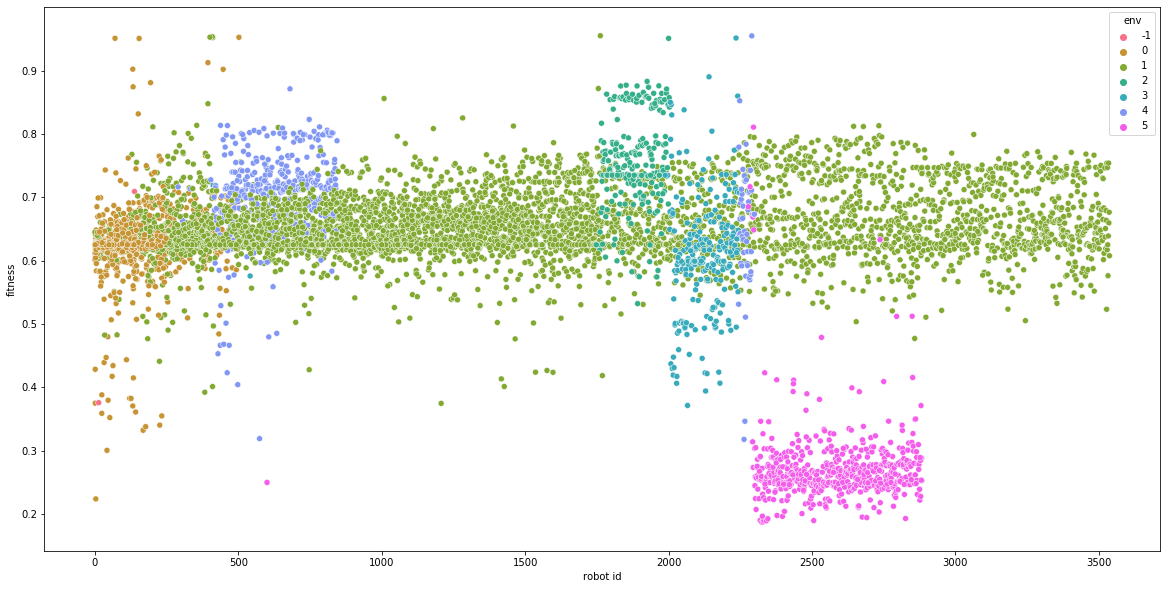

In [49]:
fig = plt.gcf()
fig.set_size_inches(20,10)
sns.scatterplot(data=data,x="robot id",y="fitness",hue="env",estimator=perc_high,palette=sns.color_palette())

## II.2 Diversity

/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 42.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.3

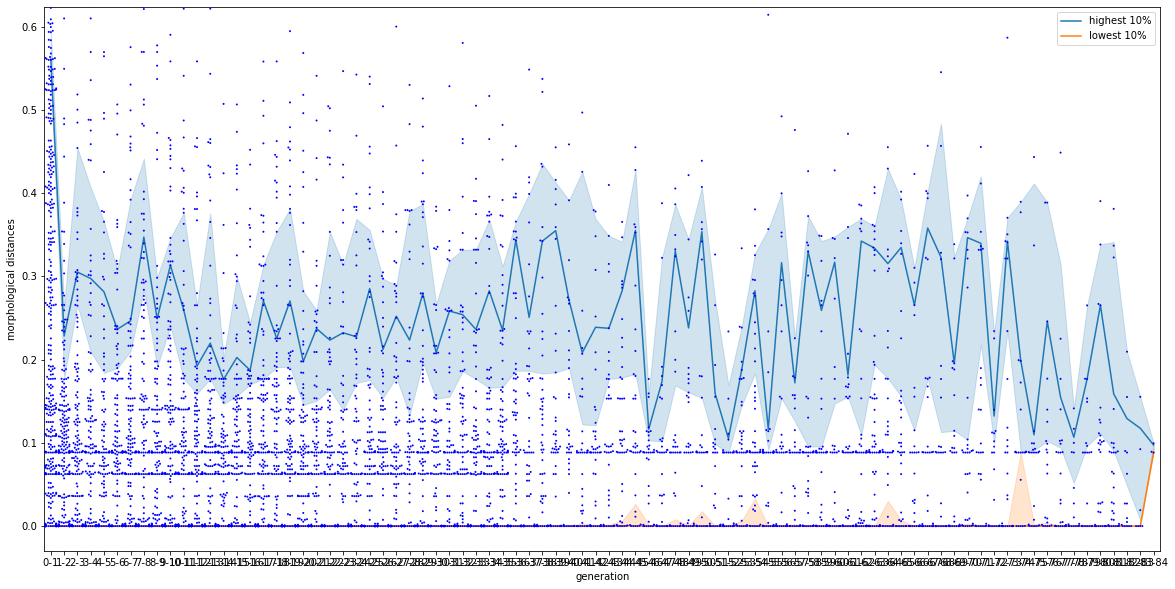

In [10]:
exp_folder = "/home/leni/are-logs/mnipes_gradual/"
lines = []

for folder in os.listdir(exp_folder):
    ids, fitnesses, parents = load_fitness(exp_folder + "/" + folder + "/fitnesses.csv")
    lineages = compute_lineage(ids,parents)
    
    descriptors = load_descriptor(exp_folder + "/" + folder + "/morph_descriptors.csv")

    for k,v in lineages.items():
        prev_id = k
        j = find_index(k,ids)
        prev_desc = descriptors[j]
        prev_fit = fitnesses[j]
        for i, _id in zip(range(len(v)),v):
            j = find_index(_id,ids)
            dist = la.norm(np.array(descriptors[j][1:])-np.array(prev_desc[1:]))
            diff_fit = fitnesses[j] - prev_fit 
            lines.append([str(prev_id) + "-" + str(_id),str(len(v) - 1 - i)+"-"+str(len(v) - i),dist,diff_fit])
            prev_id = _id
            prev_desc = descriptors[j]
            prev_fit = fitnesses[j]

data = pd.DataFrame(data=lines,columns=["id","generation","morphological distances","fitness difference"])
data = data.drop_duplicates()
fig = plt.gcf()
fig.set_size_inches(20,10)
sns.swarmplot(data=data,x="generation",y="morphological distances",size=2,color='b')
sns.lineplot(data=data,x="generation",y="morphological distances",estimator=perc_high,label="highest 10%")
sns.lineplot(data=data,x="generation",y="morphological distances",estimator=perc_low,label="lowest 10%")

/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 59.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.2

Text(0.5, 1.0, 'exploration - obstacles')

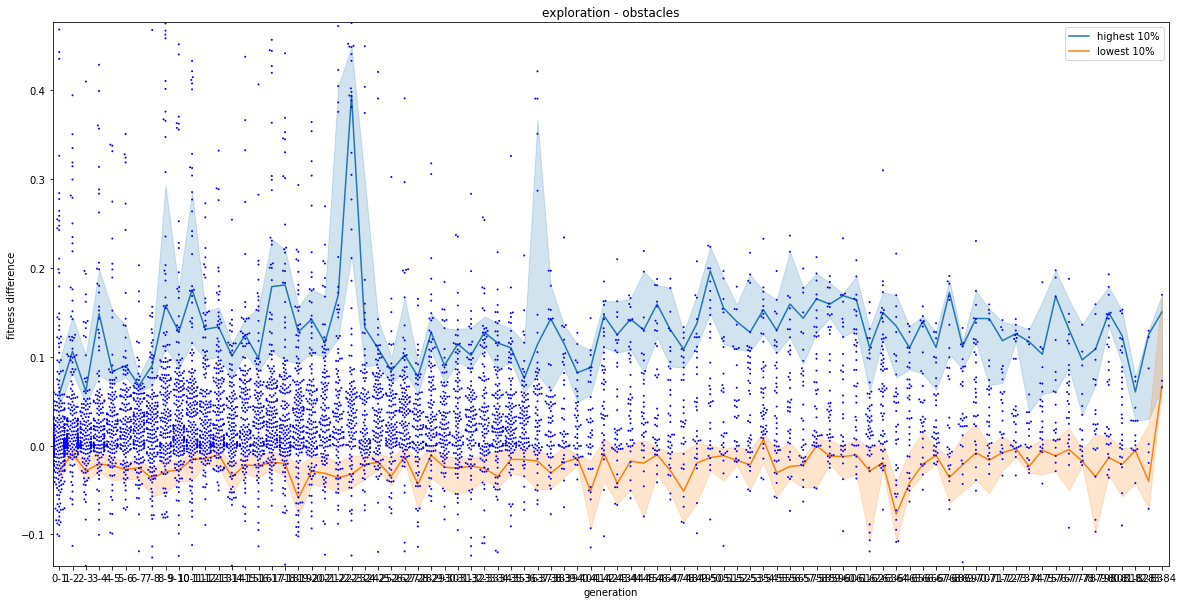

In [12]:
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.swarmplot(data=data,x="generation",y="fitness difference",size=2,color='b')
sns.lineplot(data=data,x="generation",y="fitness difference",estimator=perc_high,label="highest 10%")
sns.lineplot(data=data,x="generation",y="fitness difference",estimator=perc_low,label="lowest 10%")
ax.set_title("exploration - obstacles")

In [17]:
desc_lines = []
organ_lines = []
exp_folder = "/home/leni/are-logs/mnipes_gradual/"
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/morph_descriptors.csv")
    for desc in descriptors:
        desc_lines.append([desc[0],desc[5]*16,desc[6]*16])
wheels = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for desc in desc_lines:
        wheels[int(desc[1])]+=1
        sensors[int(desc[2])]+=1
        total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","baseline"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","baseline"])

<Figure size 360x360 with 0 Axes>

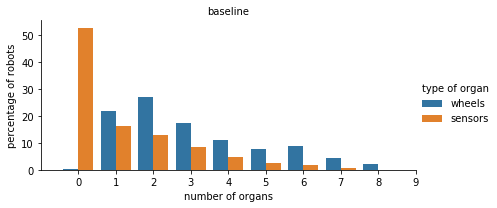

In [18]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 9)))

## Behaviours

<Figure size 648x648 with 0 Axes>

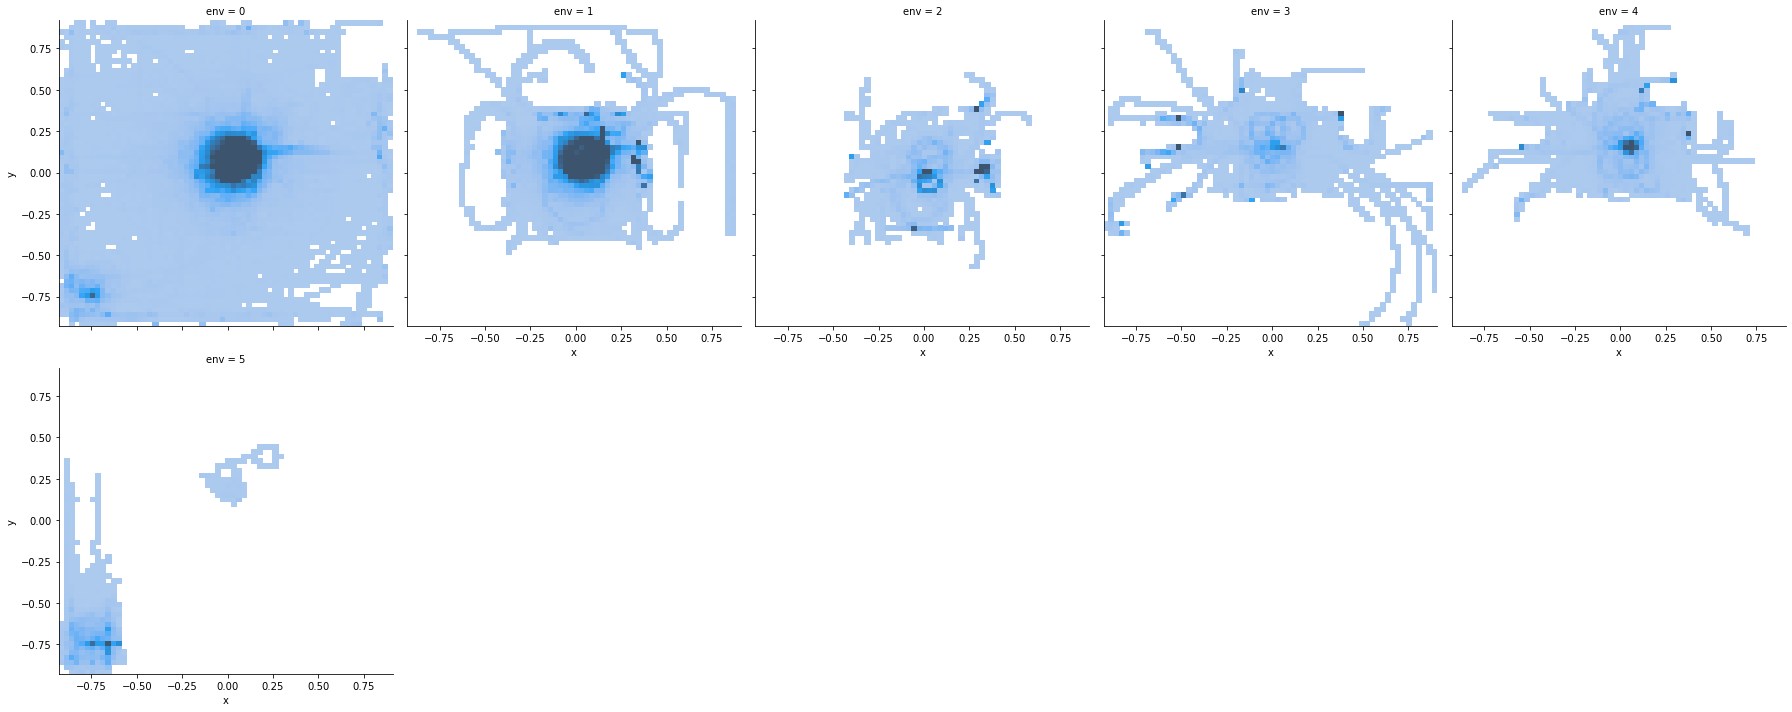

In [29]:
exp_folder = "/home/leni/are-logs/mnipes_gradual/"
trajectory = []
fig = plt.gcf()
fig.set_size_inches(9, 9)
for folder in os.listdir(exp_folder):
    for file in os.listdir(exp_folder + "/" + folder):
        if(file.split("_")[0] != "traj"):
            continue
        _id = int(file.split("_")[1])
        env = int(file.split("_")[2])
        traj = load_trajectory(exp_folder + "/" + folder + "/" + file)
        traj = [[_id,env] + t for t in traj]
        trajectory += traj

data = pd.DataFrame(data=trajectory,columns=["id","env","t","x","y","z"]) 
sns.displot(kind="hist",data=data,x="x",y="y",col="env",bins=64,legend=False,pmax=0.5,col_wrap=5)

plt.show()

<Figure size 648x648 with 0 Axes>

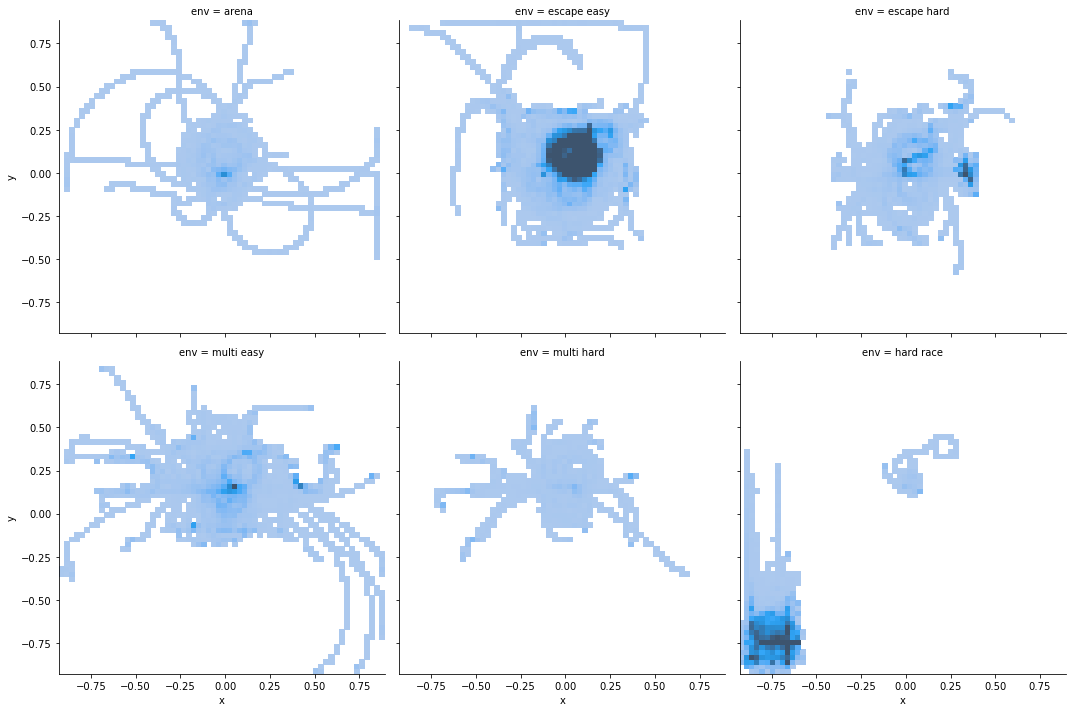

In [103]:
exp_folder = "/home/leni/are-logs/mnipes_gradual/mnipes2_16_4_12-39-1-1770-405870621/"
trajectory = []
fig = plt.gcf()
fig.set_size_inches(9, 9)
id_env = dict()
for file in os.listdir(exp_folder):
    if(file.split("_")[0] != "traj"):
        continue
    _id = int(file.split("_")[1])
    env = int(file.split("_")[2])
    traj = load_trajectory(exp_folder + "/" + file)
    if(len(traj) > 0):
        if _id in id_env:
            if env > id_env[_id]:
                id_env[_id] = env
        else:
            id_env[_id] = env
            
for _id, env in id_env.items():
    traj = load_trajectory(exp_folder + "/traj_" + str(_id) + "_" + str(env))
    traj = [[_id,env_name[env]] + t for t in traj]
    trajectory += traj

data = pd.DataFrame(data=trajectory,columns=["id","env","t","x","y","z"]) 
sns.displot(kind="hist",data=data,x="x",y="y",col="env",bins=64,legend=False,pmax=0.5,col_wrap=3,col_order=env_name)

plt.show()